In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

# ensure project root (one level up) is on PATH
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

## Notebook variables

In [3]:
video_path = "../sample_data/08fd33_4.mp4"
output_path = "../output_videos/output_video.avi"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

## Import the model

In [4]:
from utils.import_models import ModelImporter
field_model = ModelImporter().download_field_model()

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/field_recognitionv1_0/1


## Demo of the field mapper


0: 544x960 1 pitch, 70.4ms
Speed: 2.2ms preprocess, 70.4ms inference, 231.5ms postprocess per image at shape (1, 3, 544, 960)


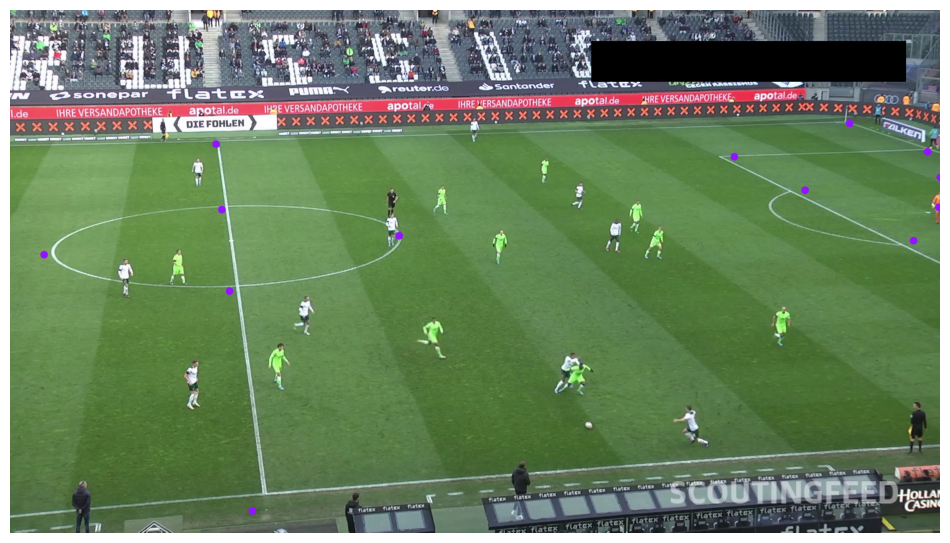

In [5]:
from utils.notebook_utils import show_image
from utils.video_utils import read_video
from trackers.field_tracker import FieldTracker
from annotators.field_annotator import FieldAnnotator

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

field_tracker = FieldTracker(field_model)
first_field_track, confidence_mask = field_tracker.get_field_keypoints(first_frame)

show_image(FieldAnnotator.annotate_frame_keypoints(first_frame.copy(), first_field_track))


0: 544x960 1 pitch, 65.0ms
Speed: 2.3ms preprocess, 65.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 960)


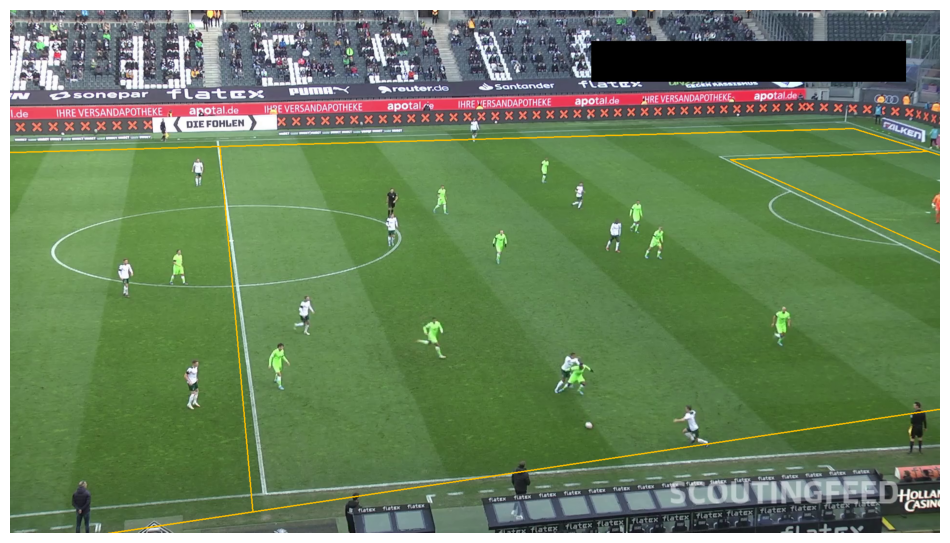

In [6]:
field_edges_keypoints = field_tracker.get_field_edges(first_frame)
show_image(FieldAnnotator.annotate_frame_edges(first_frame.copy(), field_edges_keypoints))


0: 544x960 1 pitch, 64.7ms
Speed: 2.2ms preprocess, 64.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 960)


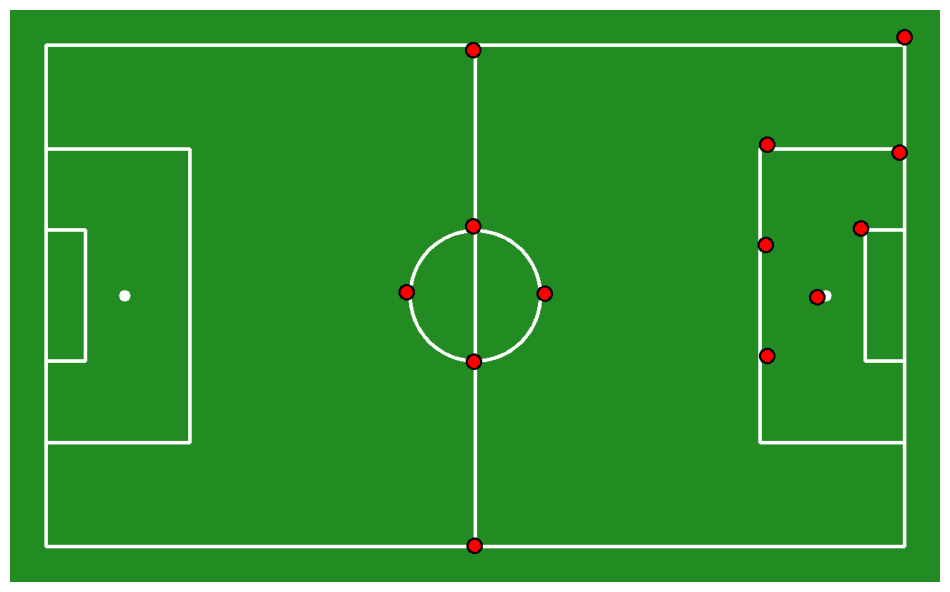

In [7]:
from annotators.pitch_utils import draw_pitch, draw_points_on_pitch
from mapping_2d.soccer_field import SoccerPitchConfiguration
import supervision as sv

mapped_vert = field_tracker.map_points_2d(first_frame, first_field_track.xy[0])

pitch_img = draw_pitch(SoccerPitchConfiguration())
pitch_img = draw_points_on_pitch(
    config=SoccerPitchConfiguration(),
    xy=mapped_vert.xy[0],
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=pitch_img)

show_image(pitch_img)

## Draw detected players on the 2d plane

In [8]:
from trackers.player_detector import PlayerDetector
players_model = ModelImporter().download_player_model()
frame_generator = read_video(video_path)
tracks_generator =  PlayerDetector(players_model).get_detections_from_frames(frame_generator)

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1



0: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 36.3ms
1: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 36.3ms
2: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 36.3ms
3: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 36.3ms
4: 544x960 1 ball, 1 goalkeeper, 20 players, 3 referees, 36.3ms
5: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 36.3ms
6: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 36.3ms
7: 544x960 1 goalkeeper, 21 players, 3 referees, 36.3ms
8: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 36.3ms
9: 544x960 1 ball, 1 goalkeeper, 21 players, 4 referees, 36.3ms
10: 544x960 1 ball, 1 goalkeeper, 21 players, 4 referees, 36.3ms
11: 544x960 1 goalkeeper, 24 players, 3 referees, 36.3ms
12: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 36.3ms
13: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 36.3ms
14: 544x960 1 ball, 21 players, 3 referees, 36.3ms
15: 544x960 1 ball, 21 players, 4 referees, 36.3ms
16: 544x960 1

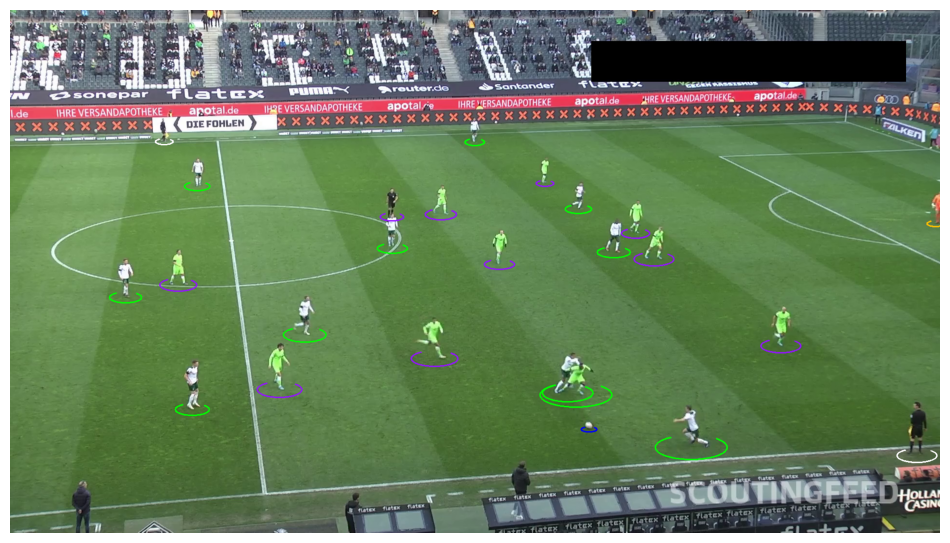

In [9]:
from annotators.player_annotator import PlayersAnnotator
from utils.notebook_utils import show_image
import itertools

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

tracks_gen1, tracks_gen2 = itertools.tee(tracks_generator)
first_players_tracks = next(tracks_gen1)

tracks_generator = tracks_gen2

annotated_sample_image = PlayersAnnotator.annotate_frame(first_frame.copy(), first_players_tracks)
show_image(annotated_sample_image)


0: 544x960 1 pitch, 73.3ms
Speed: 5.9ms preprocess, 73.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 960)


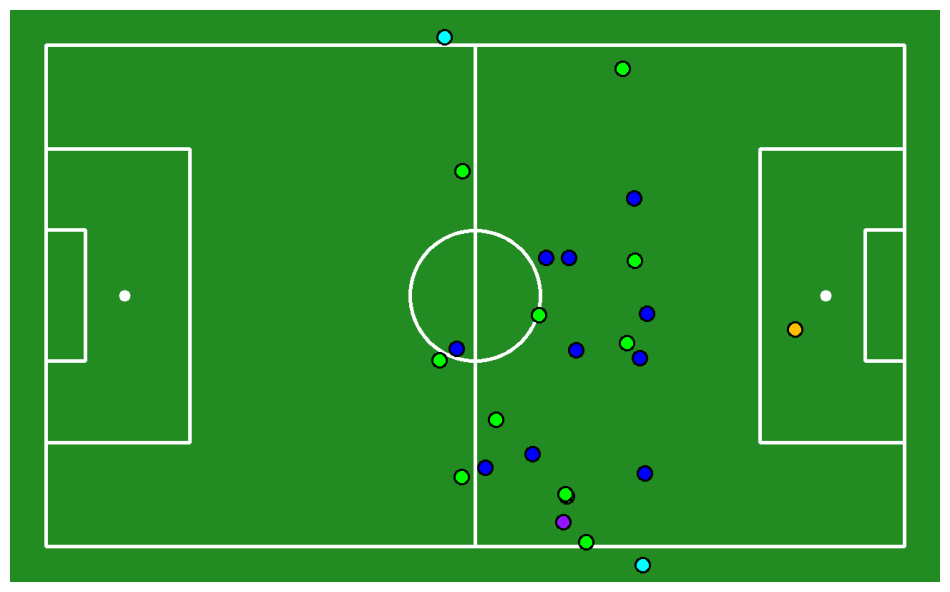

In [31]:
from annotators.pitch_2d_annotator import Pitch2DAnnotator

bottom_boxes = first_players_tracks.detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
mapped_2d_points = field_tracker.map_points_2d(first_frame, bottom_boxes)

show_image(Pitch2DAnnotator().annotate_frame(mapped_2d_points.xy[0], first_players_tracks))